In [1]:
'''RUN THIS CELL FIRST IF ON LOCAL MACHINE'''
import tensorflow.compat.v1 as tf
tf.enable_eager_execution(tf.ConfigProto(log_device_placement=False))

tf.test.gpu_device_name()

''

In [2]:


import numpy as np
from sklearn.model_selection import KFold
from itertools import product
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from sklearn.model_selection import KFold
# import early stopping
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import class_weight

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def specificity_score(y_true, y_pred):

    # Convert probabilities to binary predictions
    y_pred_bin = np.argmax(y_pred, axis=1)
    y_true_bin = np.argmax(y_true, axis=1)

    tn = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
    fp = np.sum((y_true_bin == 0) & (y_pred_bin != 0))
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return specificity

In [24]:
def train_and_evaluate(dataset_names, create_model_fn, class_weights):

    outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    # Find best dataset to train and test model on
    #dataset_names = ['X_smoothed_mean_norm']

    for dataset_name in dataset_names:

         # Load in dataset from pickle
        with open(f'drive/MyDrive/Pickles/{dataset_name}.pickle', 'rb') as handle:
            dataset = pickle.load(handle)

        dataset = np.array(dataset)

        print(f'Working on dataset: {dataset_name}')

        accuracies = []
        sensitivities = []
        false_positive_rates = []
        specificities = []
        precisions = []

        fold = 1

        for train_index, test_index in outer_cv.split(dataset):

            # Print current progress
            print(f'Working on fold: {fold}')
            fold += 1

            X_train, X_test = dataset[train_index], dataset[test_index]
            Y_train, Y_test = abnormal_encoded[train_index], abnormal_encoded[test_index]

            X_train = X_train.astype('float32')
            Y_train = Y_train.astype('float32')
            X_test = X_test.astype('float32')
            Y_test = Y_test.astype('float32')

            model = create_model_fn(X_train.shape[1:])
            early_stopping = EarlyStopping(monitor='val_loss', patience=3)

            if class_weights:

                Y_train_classes = np.argmax(Y_train, axis=1)

                # Compute class weights
                cw = class_weight.compute_class_weight('balanced',
                                                    classes=np.unique(Y_train_classes),
                                                    y=Y_train_classes)

                class_weights_dict = dict(enumerate(cw))

                #Fit the model
                print('Fitting model')
                model.fit(X_train, Y_train, epochs=5, batch_size=4, validation_split=0.2, callbacks=[early_stopping], verbose=1, class_weight=class_weights_dict)

            else:
                #Fit the model
                print('Fitting model')
                model.fit(X_train, Y_train, epochs=5, batch_size=4, validation_split=0.2, callbacks=[early_stopping], verbose=1)

            # Predict the test set
            print('Predicting test set')
            Y_pred = model.predict(X_test)

            Y_pred_classes = np.argmax(Y_pred, axis=1)
            Y_test_classes = np.argmax(Y_test, axis=1)

            # Calulate accuracy, sensitivity, false positive rate, specificity and precision
            accuracies.append(accuracy_score(Y_test_classes, Y_pred_classes))
            sensitivities.append(recall_score(Y_test_classes, Y_pred_classes, average='macro'))
            false_positive_rates.append(1 - specificity_score(Y_test, Y_pred))
            specificities.append(specificity_score(Y_test, Y_pred))
            precisions.append(precision_score(Y_test_classes, Y_pred_classes, average='macro'))



        avg_accuracy = np.mean(accuracies)
        avg_sensitivity = np.mean(sensitivities)
        avg_false_positive_rate = np.mean(false_positive_rates)
        avg_specificity = np.mean(specificities)
        avg_precision = np.mean(precisions)

        std_accuracy = np.std(accuracies)
        std_sensitivity = np.std(sensitivities)
        std_false_positive_rate = np.std(false_positive_rates)
        std_specificity = np.std(specificities)
        std_precision = np.std(precisions)

        dataset_results[dataset_name]['Accuracy'] = (avg_accuracy, std_accuracy)
        dataset_results[dataset_name]['Sensitivity'] = (avg_sensitivity, std_sensitivity)
        dataset_results[dataset_name]['False Positive Rate'] = (avg_false_positive_rate, std_false_positive_rate)
        dataset_results[dataset_name]['Specificity'] = (avg_specificity, std_specificity)
        dataset_results[dataset_name]['Precision'] = (avg_precision, std_precision)

        for dataset_name, results in dataset_results.items():
            print(f'Dataset: {dataset_name}')
            for metric, (avg, std) in results.items():
                print(f'{metric}: {avg} +/- {std}')
            print('\n')


        # Delete dataset to free up memory
        del dataset
        del Y_pred
    return dataset_results

In [25]:
# Model functions

def create_cnn_model(shape, filters=32, kernel_size=3, dropout_rate=0.5):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=shape))  # Adjust the input_shape to match your dataset
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(19301, 16)))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))  # Reduced the number of neurons in the dense layer
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(shape, lstm_units=32, dropout_rate=0.5, output_classes=3):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=shape))
    model.add(LSTM(lstm_units, return_sequences=False))  # 'return_sequences=False' because we only need the last output
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units, activation='relu'))
    model.add(Dense(output_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(shape, gru_units=32, dropout_rate=0.5, output_classes=3):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=shape))
    model.add(GRU(gru_units, return_sequences=False))  # return_sequences=False because we only need the last output
    model.add(Dropout(dropout_rate))
    model.add(Dense(gru_units, activation='relu'))
    model.add(Dense(output_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
'''RUN THIS CELL IF ON COLAB'''

# Load in dataset from pickle
with open('drive/MyDrive/Pickles/abnormal_encoded.pickle', 'rb') as handle:
    abnormal_encoded = pickle.load(handle)

abnormal_encoded = np.array(abnormal_encoded)

with open('drive/MyDrive/Pickles/AIMS.pickle', 'rb') as handle:
    AIMS = pickle.load(handle)

AIM = np.array(AIMS)

with open('drive/MyDrive/Pickles/Optimality.pickle', 'rb') as handle:
    optimality = pickle.load(handle)

optimality = np.array(optimality)

In [27]:
dataset_results = {'X_smoothed_mean_norm_month': {}, 'X_smoothed_median_norm_month': {}, 'X_smoothed_mean_norm': {}, 'X_smoothed_median_norm': {}}

cnn_dataset_result_cw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_cnn_model, True)



Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 2s 30ms/step - loss: 22.3467 - accuracy: 0.4235 - val_loss: 10.9162 - val_accuracy: 0.5909
Epoch 2/5
22/22 [==============================] - 0s 16ms/step - loss: 7.6254 - accuracy: 0.7412 - val_loss: 26.1706 - val_accuracy: 0.5000
Epoch 3/5
22/22 [==============================] - 0s 15ms/step - loss: 3.9040 - accuracy: 0.9059 - val_loss: 27.9859 - val_accuracy: 0.6818
Epoch 4/5
22/22 [==============================] - 0s 11ms/step - loss: 1.5618 - accuracy: 0.9059 - val_loss: 28.5547 - val_accuracy: 0.5909
Predicting test set
2/2 [==============================] - 0s 15ms/step
Working on fold: 2
Fitting model
Epoch 1/5
22/22 [==============================] - 1s 21ms/step - loss: 46.1282 - accuracy: 0.5412 - val_loss: 6.0454 - val_accuracy: 0.7273
Epoch 2/5
22/22 [==============================] - 0s 14ms/step - loss: 6.9497 - accuracy: 0.7176 - val_loss: 10.06

In [28]:
cnn_dataset_result_ncw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_cnn_model, False)


Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 1s 22ms/step - loss: 15.8563 - accuracy: 0.5529 - val_loss: 5.4335 - val_accuracy: 0.6818
Epoch 2/5
22/22 [==============================] - 0s 11ms/step - loss: 4.6145 - accuracy: 0.8000 - val_loss: 8.6626 - val_accuracy: 0.6364
Epoch 3/5
22/22 [==============================] - 0s 12ms/step - loss: 1.8578 - accuracy: 0.8824 - val_loss: 19.0609 - val_accuracy: 0.4091
Epoch 4/5
22/22 [==============================] - 0s 11ms/step - loss: 1.1123 - accuracy: 0.9412 - val_loss: 19.5823 - val_accuracy: 0.6818
Predicting test set
2/2 [==============================] - 0s 18ms/step
Working on fold: 2
Fitting model
Epoch 1/5
22/22 [==============================] - 2s 25ms/step - loss: 30.6900 - accuracy: 0.4588 - val_loss: 8.9566 - val_accuracy: 0.7727
Epoch 2/5
22/22 [==============================] - 0s 12ms/step - loss: 2.8553 - accuracy: 0.8824 - val_loss: 5.5423 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model
Epoch 1/5
22/22 [==============================] - 2s 29ms/step - loss: 99.9923 - accuracy: 0.4824 - val_loss: 36.3889 - val_accuracy: 0.6818
Epoch 2/5
22/22 [==============================] - 0s 17ms/step - loss: 21.3106 - accuracy: 0.7412 - val_loss: 19.0500 - val_accuracy: 0.6364
Epoch 3/5
22/22 [==============================] - 0s 16ms/step - loss: 2.9842 - accuracy: 0.8941 - val_loss: 64.2622 - val_accuracy: 0.1818
Epoch 4/5
22/22 [==============================] - 0s 16ms/step - loss: 16.1491 - accuracy: 0.7529 - val_loss: 30.6916 - val_accuracy: 0.8182
Epoch 5/5
22/22 [==============================] - 0s 16ms/step - loss: 9.5561 - accuracy: 0.8471 - val_loss: 41.8483 - val_accuracy: 0.4091
Predicting test set
2/2 [==============================] - 0s 17ms/step
Working on fold: 3
Fitting model
Epoch 1/5
22/22 [==============================] - 1s 22ms/step - loss: 32.6569 - accuracy: 0.4419 - val_loss: 9.9448 - val_accuracy: 0.5000
Epoch 2/5
22/22 [===============

In [ ]:
lstm_dataset_results_cw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_lstm_model, True)


In [ ]:
lstm_dataset_results_ncw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_lstm_model, False)


In [ ]:
gru_dataset_results_cw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_gru_model, True)


In [ ]:
gru_dataset_results_ncw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_gru_model, False)


In [36]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model

def create_multitask_cnn_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    
    # Common Dense layer
    x = Dense(64, activation='relu')(x)
    
    # Separate output layers for each task
    # Output layer for categorical variable (Abnormal)
    abnormal_output = Dense(units=3, activation='softmax', name='abnormal_output')(x)  # Assuming 3 classes for the example
    
    # Output layers for numerical scores (AIMS and optimality)
    aims_output = Dense(units=6, activation='softmax', name='aims_output')(x)  # Linear activation for regression
    optimality_output = Dense(units=1, name='optimality_output')(x)  # Linear activation for regression
    
    # Model definition with multiple outputs
    model = Model(inputs=inputs, outputs=[abnormal_output, aims_output, optimality_output])
    
    # Compile model with multiple loss functions and possibly different weights
    model.compile(optimizer='adam',
                  loss={'abnormal_output': 'categorical_crossentropy', 
                        'aims_output': 'mean_squared_error', 
                        'optimality_output': 'mean_squared_error'},
                  loss_weights={'abnormal_output': 0.5, 'aims_output': 0.5, 'optimality_output': 0.5},
                  metrics={'abnormal_output': 'accuracy', 
                           'aims_output': 'accuracy', 
                           'optimality_output': 'mae'})
    
    return model


In [18]:
def train_multitask_model(X_train, y_train_abnormal, y_train_aims, y_train_optimality, X_test, y_test_abnormal, y_test_aims, y_test_optimality):
    input_shape = X_train.shape[1:]  # Input shape of the data
    
    # Create the multitask model
    multitask_model = create_multitask_cnn_model(input_shape)
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
    # Train the model
    history = multitask_model.fit(X_train, 
                                  {'abnormal_output': y_train_abnormal, 'aims_output': y_train_aims, 'optimality_output': y_train_optimality},
                                  validation_data=(X_test, 
                                                   {'abnormal_output': y_test_abnormal, 'aims_output': y_test_aims, 'optimality_output': y_test_optimality}),
                                  epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)
    
    return multitask_model, history


In [19]:
from sklearn.model_selection import train_test_split
# Load in dataset from pickle
with open('drive/MyDrive/Pickles/X_smoothed_mean_norm_month.pickle', 'rb') as handle:
    X_smoothed_mean_norm = pickle.load(handle)

X_moothed_mean_norm = np.array(X_smoothed_mean_norm)

# Split the data into training and testing sets
X_train, X_test, y_train_abnormal, y_test_abnormal, y_train_aims, y_test_aims, y_train_optimality, y_test_optimality = train_test_split(X_smoothed_mean_norm, abnormal_encoded, AIMS, optimality, test_size=0.2, random_state=42)

# Put all data into the an array and right format
X_train = (np.array(X_train)).astype('float32')
X_test = (np.array(X_test)).astype('float32')
y_train_abnormal = (np.array(y_train_abnormal)).astype('float32')
y_test_abnormal = (np.array(y_test_abnormal)).astype('float32')
y_train_aims = (np.array(y_train_aims)).astype('float32')
y_test_aims = (np.array(y_test_aims)).astype('float32')
y_train_optimality = (np.array(y_train_optimality)).astype('float32')
y_test_optimality = (np.array(y_test_optimality)).astype('float32')



In [24]:

# Example call to the training function (assuming data is prepared)
multitask_model, history = train_multitask_model(X_train, y_train_abnormal, y_train_aims, y_train_optimality, X_test, y_test_abnormal, y_test_aims, y_test_optimality)

# Evaluate the model
results = multitask_model.evaluate(X_test, {'abnormal_output': y_test_abnormal, 'aims_output': y_test_aims, 'optimality_output': y_test_optimality}, verbose=1)

print(f"Test Loss, Test Accuracy: {results}")


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 198848.9688 - abnormal_output_loss: 9.5355 - aims_output_loss: 257293.7812 - optimality_output_loss: 140394.6562 - abnormal_output_accuracy: 0.5156 - aims_output_mae: 339.5596 - optimality_output_mae: 285.6335WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_func

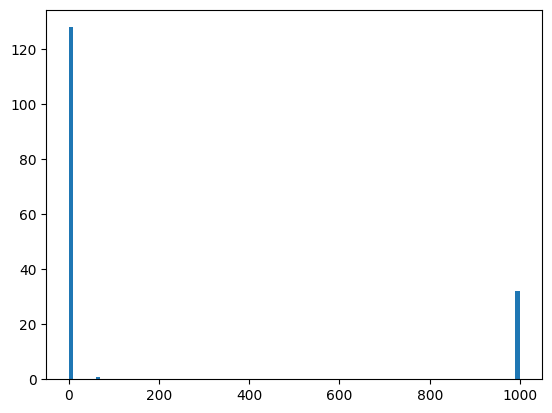

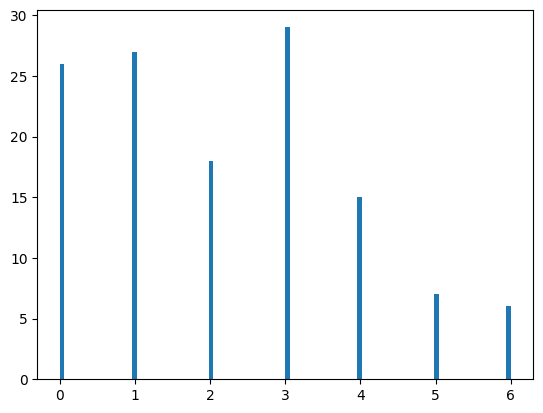

In [29]:
# visualise AIMS distribution
import matplotlib.pyplot as plt
plt.hist(AIMS, bins=100)
plt.show()

# create filtered aims where scores are not 999
filtered_aims = [i for i in AIMS if i <10]
# visualise filtered AIMS distribution
plt.hist(filtered_aims, bins=100)
plt.show()

In [30]:
# the AIMS scores > 6 are invalid. Filter out the invalid data points from AIMS, optimality, abnormal_encoded and X_smoothed_mean_norm_month
filtered_aims = [i for i in AIMS if i <6]
filtered_optimality = [optimality[i] for i in range(len(AIMS)) if AIMS[i] <6]
filtered_abnormal_encoded = [abnormal_encoded[i] for i in range(len(AIMS)) if AIMS[i] <6]
filtered_X_smoothed_mean_norm_month = [X_smoothed_mean_norm[i] for i in range(len(AIMS)) if AIMS[i] <6]


In [35]:
# one-hot encode filtered_aims
filtered_aims_encoded = []

# Use the sklearn OneHotEncoder to one-hot encode the data
from sklearn.preprocessing import OneHotEncoder

# Create the OneHotEncoder object
onehot_encoder = OneHotEncoder(sparse=False)

# One-hot encode the data
filtered_aims_encoded = onehot_encoder.fit_transform(np.array(filtered_aims).reshape(-1, 1))

print(filtered_aims_encoded)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0.

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train_abnormal, y_test_abnormal, y_train_aims, y_test_aims, y_train_optimality, y_test_optimality = train_test_split(filtered_X_smoothed_mean_norm_month, filtered_abnormal_encoded, filtered_aims_encoded, filtered_optimality, test_size=0.2, random_state=42)

# Put all data into the an array and right format
X_train = (np.array(X_train)).astype('float32')
X_test = (np.array(X_test)).astype('float32')
y_train_abnormal = (np.array(y_train_abnormal)).astype('float32')
y_test_abnormal = (np.array(y_test_abnormal)).astype('float32')
y_train_aims = (np.array(y_train_aims)).astype('float32')
y_test_aims = (np.array(y_test_aims)).astype('float32')
y_train_optimality = (np.array(y_train_optimality)).astype('float32')
y_test_optimality = (np.array(y_test_optimality)).astype('float32')

In [38]:

# Example call to the training function (assuming data is prepared)
multitask_model, history = train_multitask_model(X_train, y_train_abnormal, y_train_aims, y_train_optimality, X_test, y_test_abnormal, y_test_aims, y_test_optimality)

# Evaluate the model
results = multitask_model.evaluate(X_test, {'abnormal_output': y_test_abnormal, 'aims_output': y_test_aims, 'optimality_output': y_test_optimality}, verbose=1)

print(f"Test Loss, Test Accuracy: {results}")

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 122077.9922 - abnormal_output_loss: 35.9493 - aims_output_loss: 0.2478 - optimality_output_loss: 244119.7656 - abnormal_output_accuracy: 0.5464 - aims_output_accuracy: 0.1237 - optimality_output_mae: 396.0086WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_funct